# 5LSL0 Assignment 4: Deep Unfolding
---

In [198]:
# libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# local imports
import MNIST_dataloader

# set torches random seed
torch.random.manual_seed(0)

# define parameters
data_loc = 'D://5LSL0-Datasets'

## Loading MNIST dataset

Number of training batches: 938
Number of test batches: 157


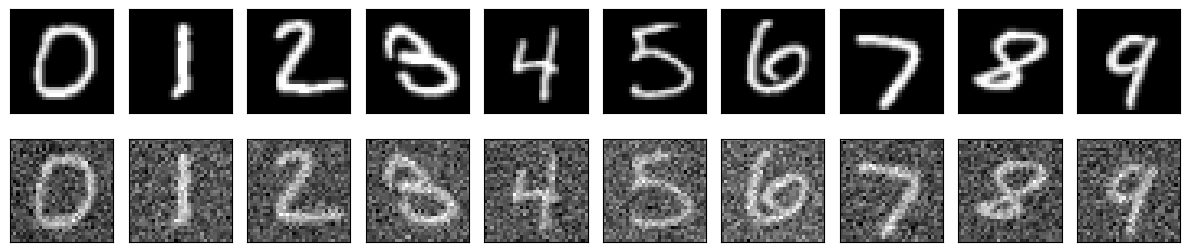

In [199]:
batch_size = 64

# get dataloader
train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

print(f"Number of training batches: {len(train_loader)}"
        f"\nNumber of test batches: {len(test_loader)}")

# get some examples as the first 10 correspond to the digits 0-9
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [200]:
# # HINT: if you do not care about going over the data in mini-batches but rather want the entire dataset use:
# x_clean_train = train_loader.dataset.Clean_Images
# x_noisy_train = train_loader.dataset.Noisy_Images
# labels_train  = train_loader.dataset.Labels

# x_clean_test  = test_loader.dataset.Clean_Images
# x_noisy_test  = test_loader.dataset.Noisy_Images
# labels_test   = test_loader.dataset.Labels

# # use these 10 examples as representations for all digits
# x_clean_example = x_clean_test[0:10,:,:,:]
# x_noisy_example = x_noisy_test[0:10,:,:,:]
# labels_example = labels_test[0:10]

## Exercise 1 - ISTA

### (a) [3 pt] Create a Python function that implements ISTA for MNIST denoising. 

Make sure the function takes as inputs: step size μ, shrinkage parameter λ, number of iteration K, and measurements (batch of MNIST images) y. It should output the final batch of reconstructions xK .

hint: the images are normalized between -1 and 1, which means the background of the
images is not at zero. Think about how to still aply ISTA correctly.

In [201]:
# Soft thresholding function
def softthreshold(x, shrinkage):
    return torch.sign(x) * torch.max(torch.abs(x) - shrinkage, torch.tensor(0.0))

# ISTA function
def ISTA(mu, shrinkage, K, y):
    # Initialize x to be the same as y
    x = y.clone() 
    
    # Iteratively apply the soft thresholding function
    for _ in tqdm(range(K)):
        # Compute the gradient
        x = x - mu * (x - y)
        # Shrinkage step
        x = softthreshold(x, mu * shrinkage)
    
    # Normalize the final batch of reconstructions to be between -1 and 1
    x = 2 * (x - x.min()) / (x.max() - x.min()) - 1
    
    # Return the final batch of reconstructions
    return x

### (b) [2 pt] Use your ISTA algorithm on 10 example images. 

Show them in a figure consisting of 10 collumns (1 per digit) and 3 rows. Row 1 should contain the noisy
measurement, row 2 the reconstruction, and row 3 the actual ground truth target.
You will have to play with the values for μ, λ, and K. Explain what you see.

Clean images: min=-1.0, max=1.0
Noisy images: min=-2.977809429168701, max=3.1102750301361084


100%|██████████| 10/10 [00:00<00:00, 626.68it/s]


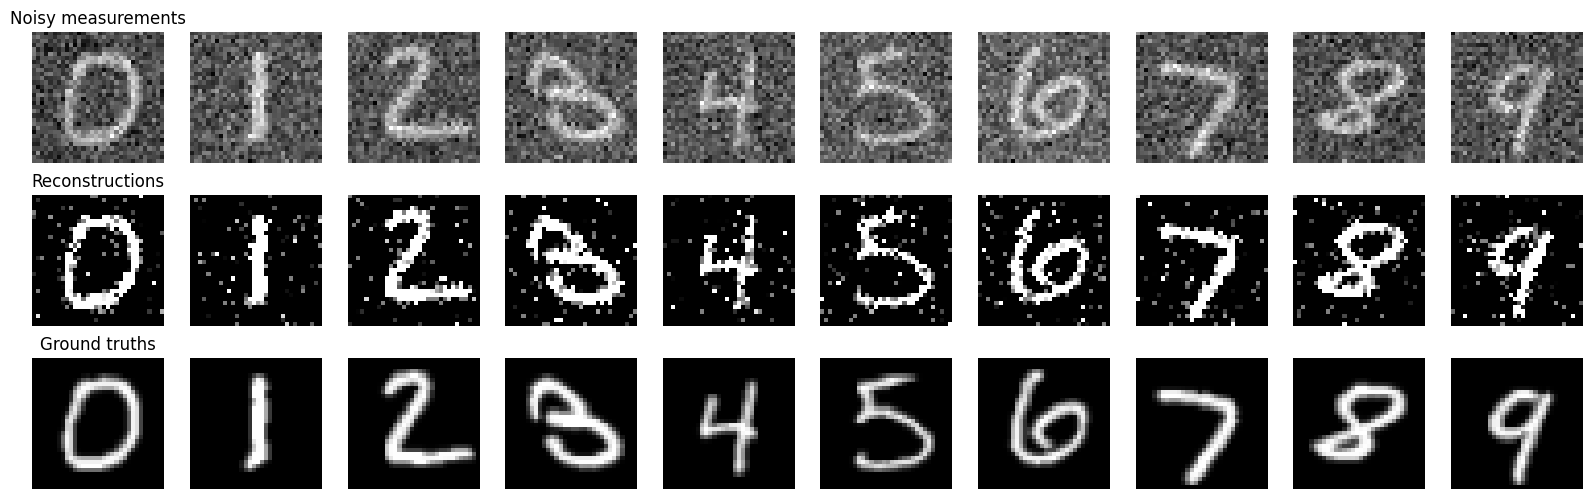

In [202]:
mu = 5.0
shrinkage = 0.05
K = 10

# print values for clean and noisy images
print(f"Clean images: min={x_clean_example.min()}, max={x_clean_example.max()}")
print(f"Noisy images: min={x_noisy_example.min()}, max={x_noisy_example.max()}")

# Apply the ISTA algorithm to the noisy example images
x_reconstructed = ISTA(mu, shrinkage, K, x_noisy_example)

# Create a figure with 10 columns and 3 rows
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

# For each column
for i in range(10):
    # Display the noisy measurement in the first row
    axs[0, i].imshow(x_noisy_example[i].squeeze(), cmap='gray')
    axs[0, i].axis('off')
    
    # Display the reconstruction in the second row
    axs[1, i].imshow(x_reconstructed[i].squeeze(), cmap='gray')
    axs[1, i].axis('off')
    
    # Display the ground truth in the third row
    axs[2, i].imshow(x_clean_example[i].squeeze(), cmap='gray')
    axs[2, i].axis('off')

# Set the titles for the rows
axs[0, 0].set_title('Noisy measurements')
axs[1, 0].set_title('Reconstructions')
axs[2, 0].set_title('Ground truths')

# Display the figure
plt.show()

### (c) [1 pt] get a numerical estimate for the performance of ISTA
run it on the entire test set and report the resulting mean squared error (mse).

In [203]:
# Load the entire test set
x_clean_test = test_loader.dataset.Clean_Images
x_noisy_test = test_loader.dataset.Noisy_Images

# Apply the ISTA algorithm to all test images
x_test_reconstructed = ISTA(mu, shrinkage, K, x_noisy_test)

# Calculate the MSE over the entire test dataset
mse_test = torch.mean((x_clean_test - x_test_reconstructed)**2)

print('Average MSE over test set:', mse_test.item())

100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Average MSE over test set: 0.12154249101877213


## Exercise 2 - LISTA

### (a) [4 pt] Implement LISTA for 3 unfolded iterations. 

Train it for at least 10 epochs and plot the loss in terms of either epochs or number of batches seen. Make suitable
choices for all the hyper-parameters.

### (b) [2 pt] Repeat exercise 1b using your trained LISTA.

### (c) [1 pt] Repeat exercise 1c using your trained LISTA.

### (d) [1 pt] As you know, neural networks need non-linear activation functions to learn a smarter mapping than just a linear one. 
Where is/are the non-linear activation functions in LISTA, if there even are any?

Answer: [Response here]